In [94]:
import os
import sys
sys.path.append('../')
import numpy as np
import scipy.io as scio
import h5py
import hdf5storage
from numpy.fft import fft, ifft, fft2, ifft2, fftshift, ifftshift
import numba
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tempfile import gettempdir
from kwave.ksource import kSource
from kwave.kspaceFirstOrder2D import kspaceFirstOrder2DC
from kwave.utils import *
from kwave.ktransducer import *
from kwave.kmedium import kWaveMedium
from utils.simulations import get_water_SoS

os.environ["CUDA_VISIBLE_DEVICES"] = '0'

%matplotlib inline

### Load Initial Pressure

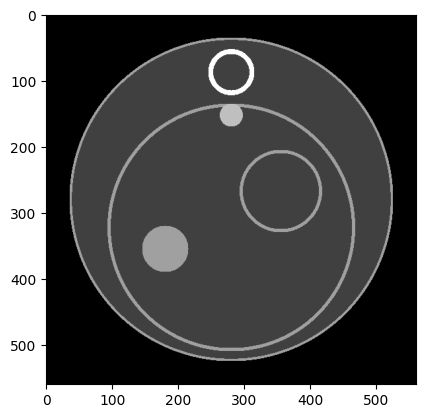

In [95]:
data_path = '../data'
data = h5py.File(os.path.join(data_path, 'IP.mat'))
IP_img = np.array(data['IP'])

plt.imshow(IP_img, cmap='gray')

Pad the image to the size of the computaional grid.

In [96]:
pad_x, pad_y = 2544, 2544 # 2024, 2024
IP_pad = np.zeros((pad_x, pad_y))
pad_start, pad_end = (pad_x-IP_img.shape[0])//2, (pad_x+IP_img.shape[1])//2
IP_pad[pad_start:pad_end, pad_start:pad_end] = IP_img
# np.save('../data/IP_pad.npy', IP_pad)

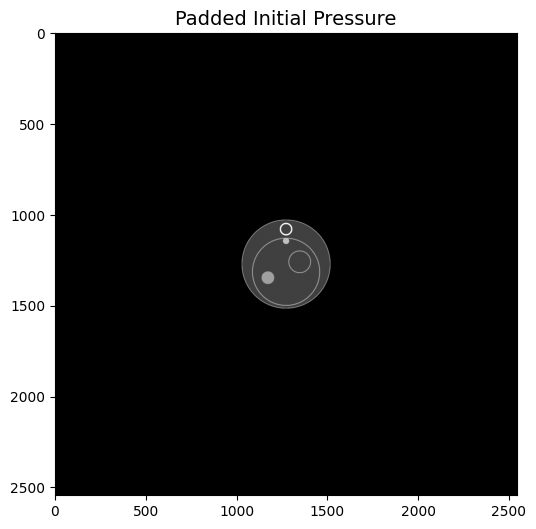

In [97]:
plt.figure(figsize=(6,6))
plt.title('Padded Initial Pressure', fontsize=14)
plt.imshow(IP_pad, cmap='gray')

In [98]:
pathname = gettempdir()

PML_size = 8                                # Size of the PML in grid points.
Nx, Ny = IP_pad.shape
R_ring = 0.05                               # Radius of the ring array [m].
dx, dy = 4.e-5, 4.e-5                       # Grid point spacing in the y direction [m].
T_sample = 1/160e6                           # Sample time step [s].

N_transducer = 512                          # Number of transducers in ring array.
center_pos = [0, 0]
arc_angle = 2 * np.pi
kgrid = kWaveGrid([Nx, Ny], [dx, dy])

Define SoS distribution.

Load speed of sound distribution.

(560, 560)


<Figure size 700x700 with 0 Axes>

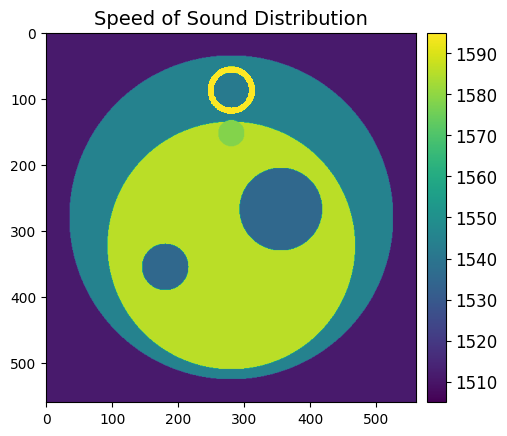

In [99]:
data = h5py.File('../data/SoS.mat')
SoS = np.array(data['SoS'])
print(SoS.shape)

plt.figure(figsize=(7,7))
norm = matplotlib.colors.Normalize(vmax=1595, vmin=1505)
fig, ax = plt.subplots()
plt.title('Speed of Sound Distribution', fontsize=14)
plt.imshow(SoS, norm=norm)
cax = fig.add_axes([ax.get_position().x1+0.017, ax.get_position().y0, 0.03, ax.get_position().height])
cb = plt.colorbar(cax=cax, norm=norm)
cb.ax.tick_params(labelsize=13)
# cb.ax.set_yticks([1500, 1520, 1540, 1560, 1580, 1600])
plt.tick_params(labelsize=12)
plt.show()

In [100]:
R, R1 = 9.2e-3, 4.5e-3          # Radius of circles in SoS distribution. [m]
offset = (1.2e-3, 9e-4)           # Offset of circle in SoS distribution.[m]
v0, v1, v2 = get_water_SoS(31), 1600, 1650             # SoS of the two circles. [m/s]
SoS_das = 1515.0 # SoS used in DAS when medium is not uniform. [m/s]

XX, YY = np.meshgrid(kgrid.x_vec.copy(), kgrid.y_vec.copy())
rou = 1000 # Density.

In [101]:
SoS_pad = np.ones((pad_x, pad_y)) * v0
SoS_pad[pad_start:pad_end, pad_start:pad_end] = SoS
SoS = SoS_pad
medium = kWaveMedium(sound_speed=SoS_pad, sound_speed_ref=v0, density=rou)

Draw the SoS distribution and the size of image.

<Figure size 700x700 with 0 Axes>

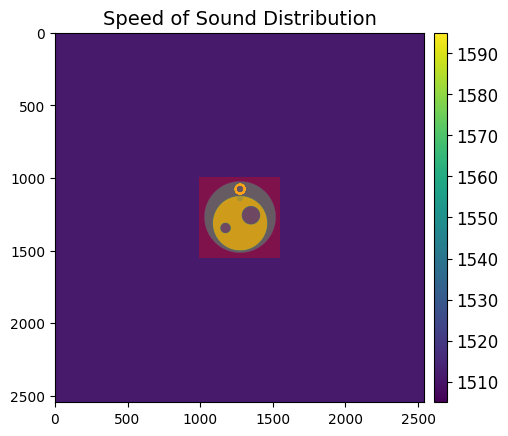

In [102]:
plt.figure(figsize=(7,7))
fig, ax = plt.subplots()
norm = matplotlib.colors.Normalize(vmax=1595, vmin=1505)
plt.title('Speed of Sound Distribution', fontsize=14)
plt.imshow(SoS, norm=norm)
left, bottom, width, height = (pad_x//2-280, pad_y//2-280, 560, 560)
image = mpatches.Rectangle((left,bottom), width, height, alpha=0.3, facecolor="red")
plt.gca().add_patch(image) # Show the size of image.
cax = fig.add_axes([ax.get_position().x1+0.015, ax.get_position().y0, 0.02, ax.get_position().height])
cb = plt.colorbar(cax=cax)
cb.ax.tick_params(labelsize=13)
# cb.ax.set_yticks([1500, 1530, 1560, 1590, 1620, 1650])
plt.tick_params(labelsize=12)
# plt.savefig('../figures/SoS.jpg', bbox_inches='tight')

### K-wave Forward Simulation

In [103]:
source = kSource()
source.p0 = IP_pad

# Smooth the initial pressure distribution and restore the magnitude.
source.p0 = smooth(source.p0, True)

cart_sensor_mask = makeCartCircle(R_ring, N_transducer, center_pos, arc_angle)
sensor = kSensor(cart_sensor_mask) # Assign to sensor structure.

# Create the time array.
kgrid.makeTime(medium.sound_speed)
kgrid.setTime(8000, T_sample) 

# Set the input arguements: force the PML to be outside the computational grid switch off p0 smoothing within kspaceFirstOrder2D.
input_args = {
    'PMLInside': False,
    'PMLSize': PML_size,
    'Smooth': False,
    'SaveToDisk': os.path.join(pathname, 'example_input.h5'),
    'SaveToDiskExit': False,
}

# Run the simulation.
sensor_data = kspaceFirstOrder2DC(**{
    'medium': medium,
    'kgrid': kgrid,
    'source': source,
    'sensor': sensor,
    **input_args
})

print(sensor_data.shape)

  start time: 12-Feb-2024-16-47-28
Running k-Wave simulation...
  start time: 12-Feb-2024-16-47-28
  reference sound speed:  1511.4390936112618 m/s
  reference sound speed:  1511.4390936112618 m/s
  dt:  6.25ns , t_end: 49.9938us , time steps: 8000
  input grid size: 2544 by 2544 grid points (101.76 by 101.76 m)
  maximum supported frequency:  18.893M Hz
  expanding computational grid...
  computational grid size: 2560 by 2560 grid points
  precomputation completed in  0.23423113953322172 s
  saving input files to disk...
  completed in  1 min 37.148285334929824 s
┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:                   NVIDIA GeForce RTX 2080 Ti │
│ Number of CPU threads:         

Downsample the sensor data.

In [104]:
sensor_data = sensor_data[:, ::4]

In [105]:
def reorder_binary_sensor_data(sensor_data, sensor, kgrid, PML_size):

    x_sensor = kgrid.x[sensor.mask[PML_size:-PML_size,PML_size:-PML_size] == 1]
    y_sensor = kgrid.y[sensor.mask[PML_size:-PML_size,PML_size:-PML_size] == 1]
    
    angle = np.arctan2(-x_sensor, -y_sensor)
    angle[angle < 0] = 2 * np.pi + angle[angle < 0]
    reorder_index = np.argsort(angle)
    
    return sensor_data[reorder_index]

sensor_data = reorder_binary_sensor_data(sensor_data, sensor, kgrid, PML_size)

Apply transducer effect.

In [106]:
def transducer_response(sensor_data):
    sensor_data = np.append(sensor_data, np.zeros((sensor_data.shape[0],1)), axis=1)
    return -2 * (sensor_data[:,1:] - sensor_data[:,:-1])

sinogram = transducer_response(sensor_data)

In [107]:
file_name = os.path.join(data_path, 'sinogram_simulation.mat')
if os.path.exists(file_name):
    os.remove(file_name)
data = {'sinogram': sinogram.swapaxes(0,1)}
hdf5storage.savemat(file_name, data)

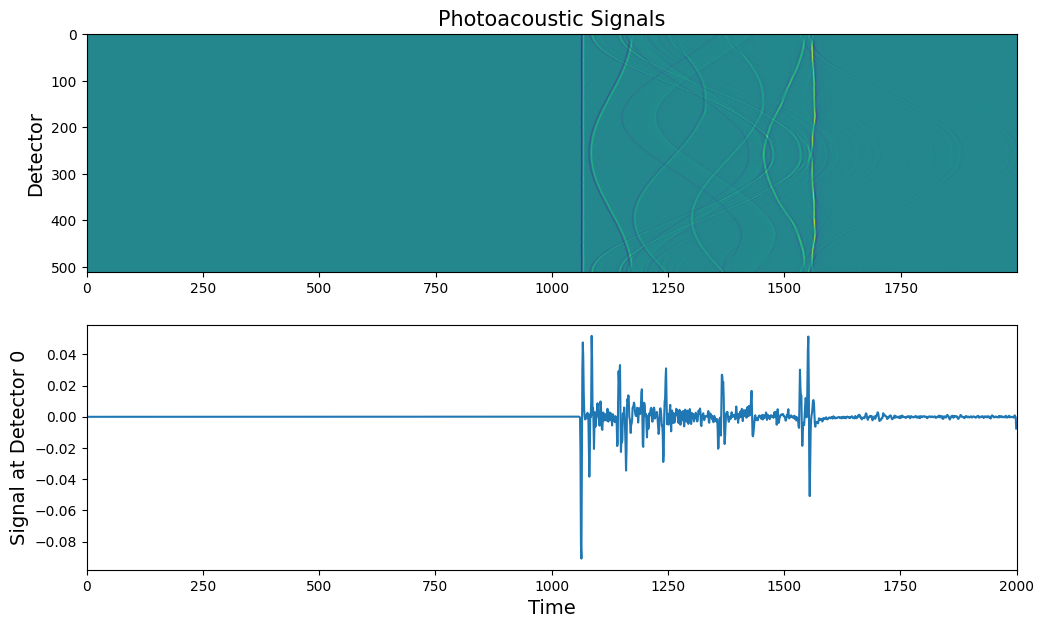

In [108]:
fig = plt.figure(figsize=(12,7))
plt.subplot(2,1,1)
plt.title('Photoacoustic Signals', fontsize=15)
plt.ylabel('Detector', fontsize=14)
plt.imshow(sinogram)

ax = plt.subplot(2,1,2)
plt.plot(sinogram[0,:])
plt.xlabel('Time', fontsize=14)
plt.ylabel('Signal at Detector 0', fontsize=14)
plt.xlim(0, 2000)
plt.show()
# plt.savefig('../figures/sinogram.jpg', bbox_inches='tight')

(1, 2000)


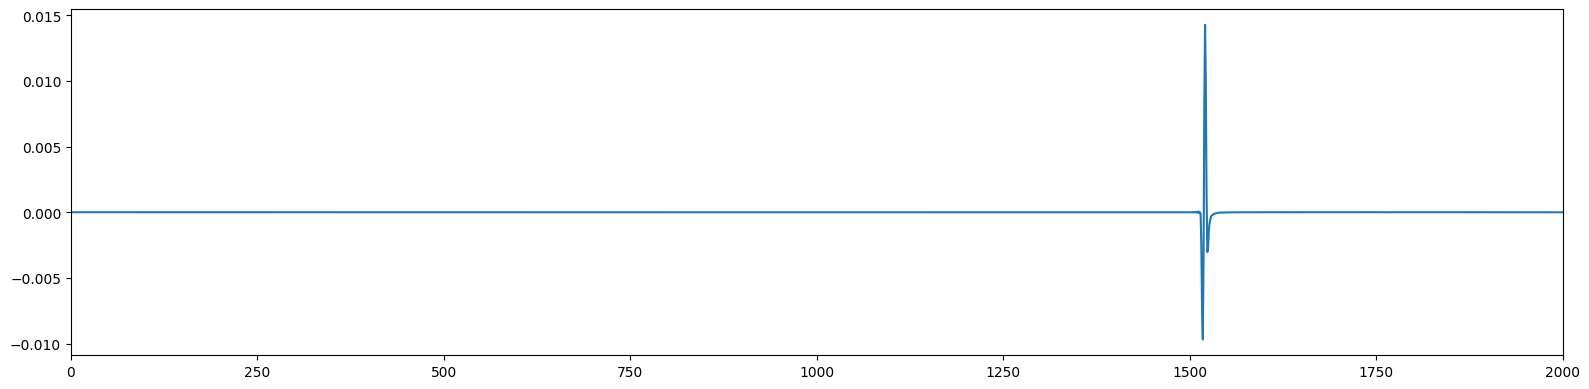

In [109]:
EIR_data = h5py.File('data/EIR_KWAVE.mat')
EIR = np.array(EIR_data['ht'])
EIR = np.append(EIR, 0)
EIR = -2 * (EIR[1:] - EIR[:-1])
EIR = np.expand_dims(EIR, axis=0)
print(EIR.shape)

time = np.linspace(0, 2000, 2000)
plt.figure(figsize=(16,4))
plt.plot(time, np.squeeze(EIR[:2000]))
plt.xlim(0, 2000)
plt.tight_layout()

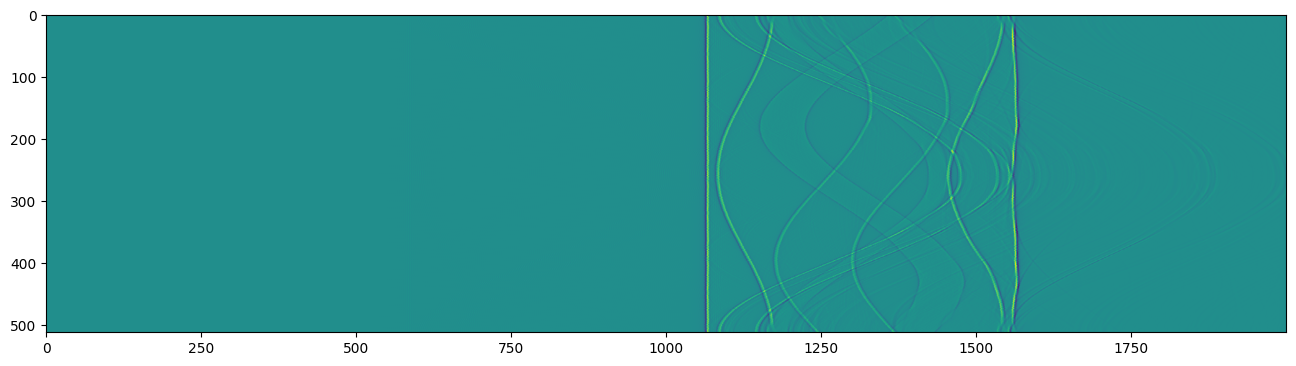

In [110]:
def deconvolve_sinogram(sinogram, EIR, t0):
    delta = np.zeros_like(EIR)
    delta[0, t0] = 1
    
    delta_ft = fft(delta, axis=1)
    EIR_ft = fft(EIR, axis=1)
    Sinogram_ft = fft(sinogram, axis=1)
    Sinogram_ft *= np.exp(1j * (np.angle(delta_ft) - np.angle(EIR_ft)))
    sinogram_deconv = np.real(ifft(Sinogram_ft, axis=1))
    
    return sinogram_deconv

t0 = np.argmax(EIR)    
sinogram_deconv = deconvolve_sinogram(sinogram, EIR, t0)
plt.subplots(figsize=(16,5))
plt.imshow(sinogram_deconv)
plt.show()

### DAS Reconstruction

In [111]:
@numba.jit(nopython=True) 
def delay_and_sum(R_ring, T_sample, V_sound, Sinogram, ImageX, ImageY, d_delay=0):
    """Generate a 2D Delay And Sum reconstructed PACT image of ring transducer array. This function is accelerated by `numba.jit` on a GPU.

    Args:
        R_ring (`float`): The R_ring [m] of the ring transducer array.
        T_sample (`float`): Sample time interval [s] of the signals.
        V_sound (`float`): The sound speed [m/s] used for Delay And Sum reconstruction.
        Sinogram (`numpy.ndarray`): A 2D array and each column of it is the signal recievde by one transducer. The nummber of transducers should be the number of columns. The transducers should be evenly distributed on a circle in counterclockwise arrangement and the first column correspond to the transducer in the dirrection `2pi/N` in the first quartile. The first sample should be at time 0 when the photoacoustic effect happens.
        ImageX (`numpy.ndarray`): The vector [m] defining the x coordinates of the grid points on which the reconstruction is done. The values in the vector should be unifromly-spaced in ascending order. The origin of the cartesian coordinate system is the center of the ring array.
        ImageY (`numpy.ndarray`): The vector [m] defining the y coordinates of the grid points on which the reconstruction is done. The values in the vector should be unifromly-spaced in ascending order. The origin of the cartesian coordinate system is the center of the ring array.
        d_delay (`float`): The delay distance [m] of the signals used in DAS. The default value is 0.

    Returns:
        `numpy.ndarray`: A 2D array of size `(len(ImageY), len(ImageX))`. `Image[t, s]` is the reconstructed photoacoustic amplitude at the grid point `(ImageX[s], ImageY[t])`.
    """

    N_transducer = Sinogram.shape[0]
    Image = np.zeros((len(ImageX), len(ImageY)))
    delta_angle = 2*np.pi / N_transducer
    angle_transducer = delta_angle * (np.arange(N_transducer,) + 1)

    x_transducer = R_ring * np.sin(angle_transducer - np.pi)
    y_transducer = R_ring * np.cos(angle_transducer - np.pi)
    
    related_data = np.zeros((N_transducer,))
    
    for s in range(len(ImageX)):
        for t in range(len(ImageY)):
            distance_to_transducer = np.sqrt((x_transducer - ImageX[s])**2 + (y_transducer - ImageY[t])**2) - d_delay
            for k in range(N_transducer):
                id = floor(distance_to_transducer[k]/(V_sound * T_sample))
                if id > Sinogram.shape[1] or id < 0:
                    related_data[k] = 0
                else:
                    related_data[k] = Sinogram[k, id]
            Image[t, s] = related_data.mean()
    return Image

In [112]:
def get_delays(R, v0, v1, n_delays, mode='linear'):
    if mode == 'linear':
        return np.linspace(0, (1-v0/v1) * R, n_delays)
    elif mode == 'quadric':
        return (1-v0/v1) * R * np.sqrt(np.linspace(0,1,n_delays))
    else:
        raise NotImplementedError
    
n_delays = 8
delays = get_delays(R, v0, v1, n_delays, 'linear')
print(delays)

recons = []
for d_delay in delays:
    recon = delay_and_sum(R_ring,
                          1/40e6,
                          v0,
                          sinogram_deconv,
                          kgrid.x_vec[pad_start:pad_end],
                          kgrid.y_vec[pad_start:pad_end],
                          d_delay=d_delay)
    recons.append(recon)

[0.00000000e+00 7.27464588e-05 1.45492918e-04 2.18239376e-04
 2.90985835e-04 3.63732294e-04 4.36478753e-04 5.09225212e-04]


In [113]:
obs_imgs = np.stack(recons, axis=0)
# np.save(os.path.join(data_path, "obs_full_imgs.npy"), obs_imgs)

Text(0.5, 1.0, 'Histogram of Gold Standard')

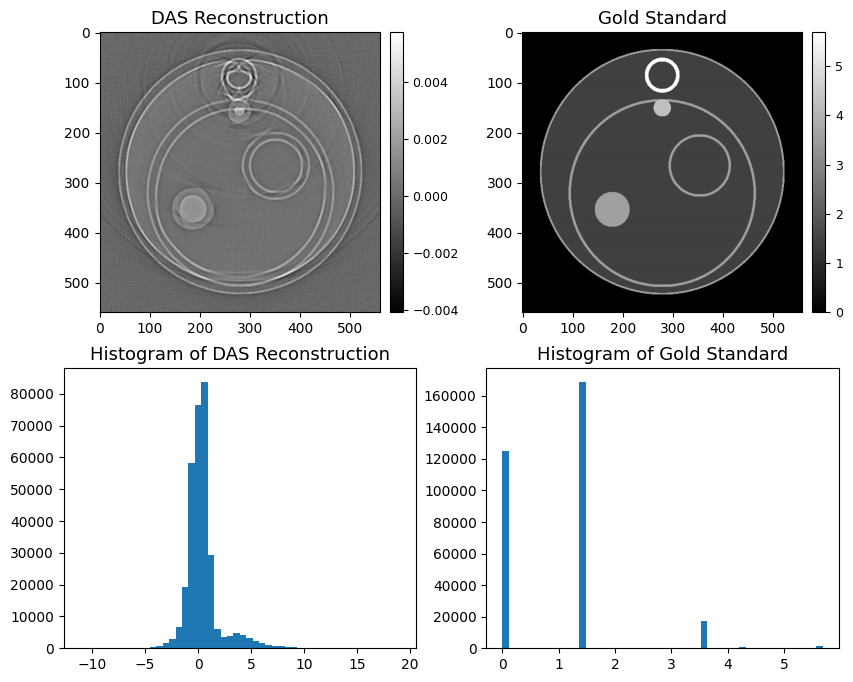

In [114]:
fig = plt.figure(figsize=(10,8))
vmax = np.max([recons[3].max(), IP_img.max()])
vmin = np.min([recons[3].min(), IP_img.min()])
norm = matplotlib.colors.Normalize(vmax=vmax, vmin=vmin)

recons[3] = recons[3] / np.abs(recons[3]).mean()
ax1 = plt.subplot(2,2,1)
plt.imshow(recons[0], cmap='gray')
plt.title('DAS Reconstruction', fontsize=13)
cax1 = fig.add_axes([ax1.get_position().x1+0.01, ax1.get_position().y0, 0.013, ax1.get_position().height])
cb1 = plt.colorbar(cax=cax1)
cb1.ax.tick_params(labelsize=9)
# cb1.ax.set_yticks([-0.2, -0.1, 0.0, 0.1])

plt.subplot(2,2,3)
plt.hist((recons[3]).ravel(), bins=50)
plt.title('Histogram of DAS Reconstruction', fontsize=13)
  
IP_img = IP_img / np.abs(IP_img).mean()
ax2 = plt.subplot(2,2,2)
plt.imshow(IP_img, cmap='gray')
plt.title('Gold Standard', fontsize=13)
cax2 = fig.add_axes([ax2.get_position().x1+0.01, ax2.get_position().y0, 0.013, ax2.get_position().height])
cb2 = plt.colorbar(cax=cax2)
cb2.ax.tick_params(labelsize=9)


plt.subplot(2,2,4)
plt.hist(IP_img.ravel(), bins=50)
plt.title('Histogram of Gold Standard', fontsize=13)

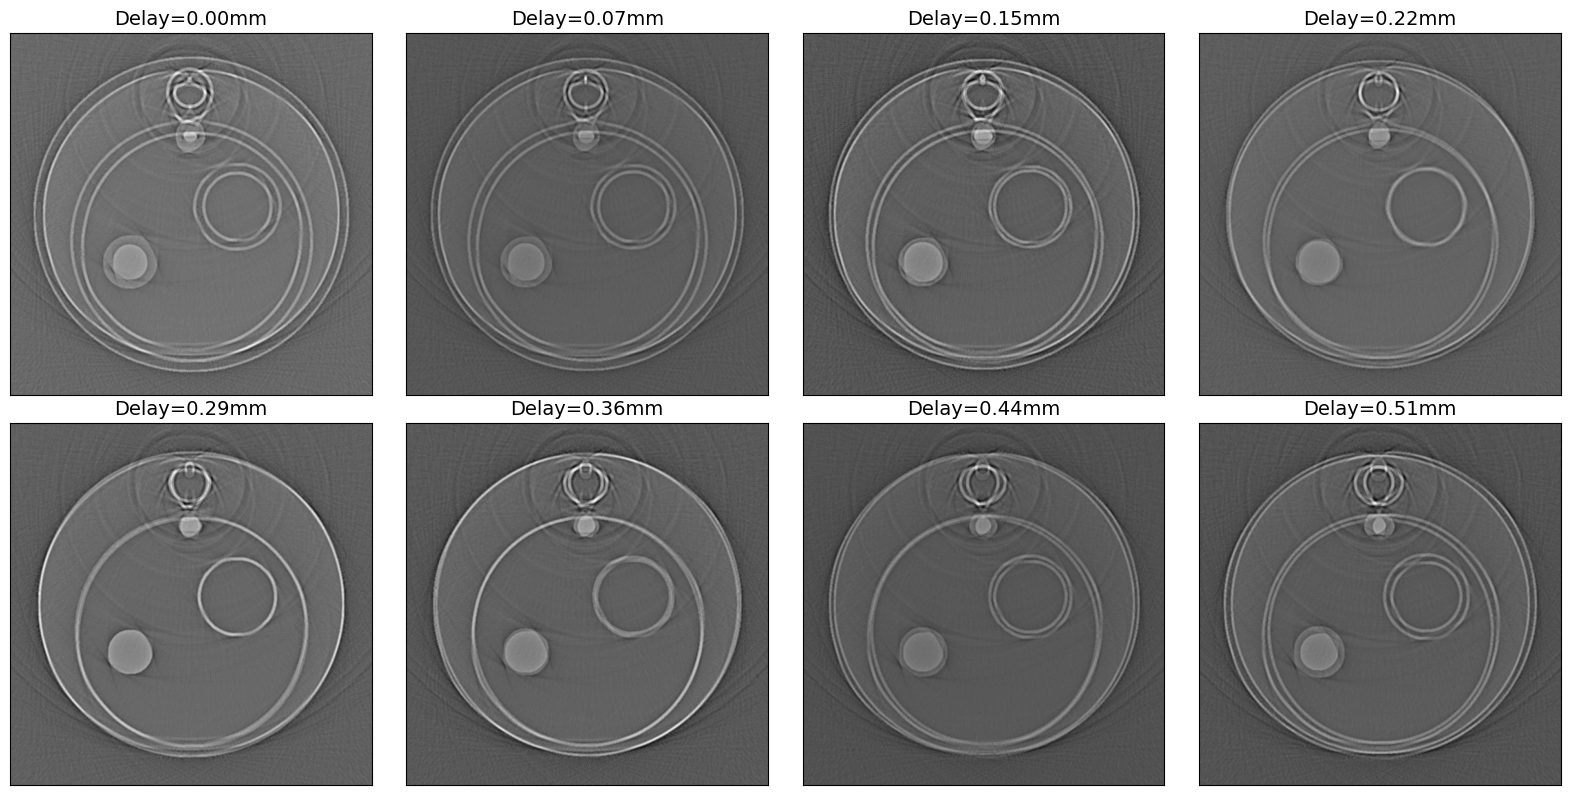

In [115]:
plt.figure(figsize=(16, 8))
for idx, d_delay in enumerate(delays):
    ax1 = plt.subplot(2,4,idx+1)
    plt.imshow(recons[idx], cmap='gray')
    plt.title('Delay={:.2f}mm'.format(d_delay*1e3), fontsize=14)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

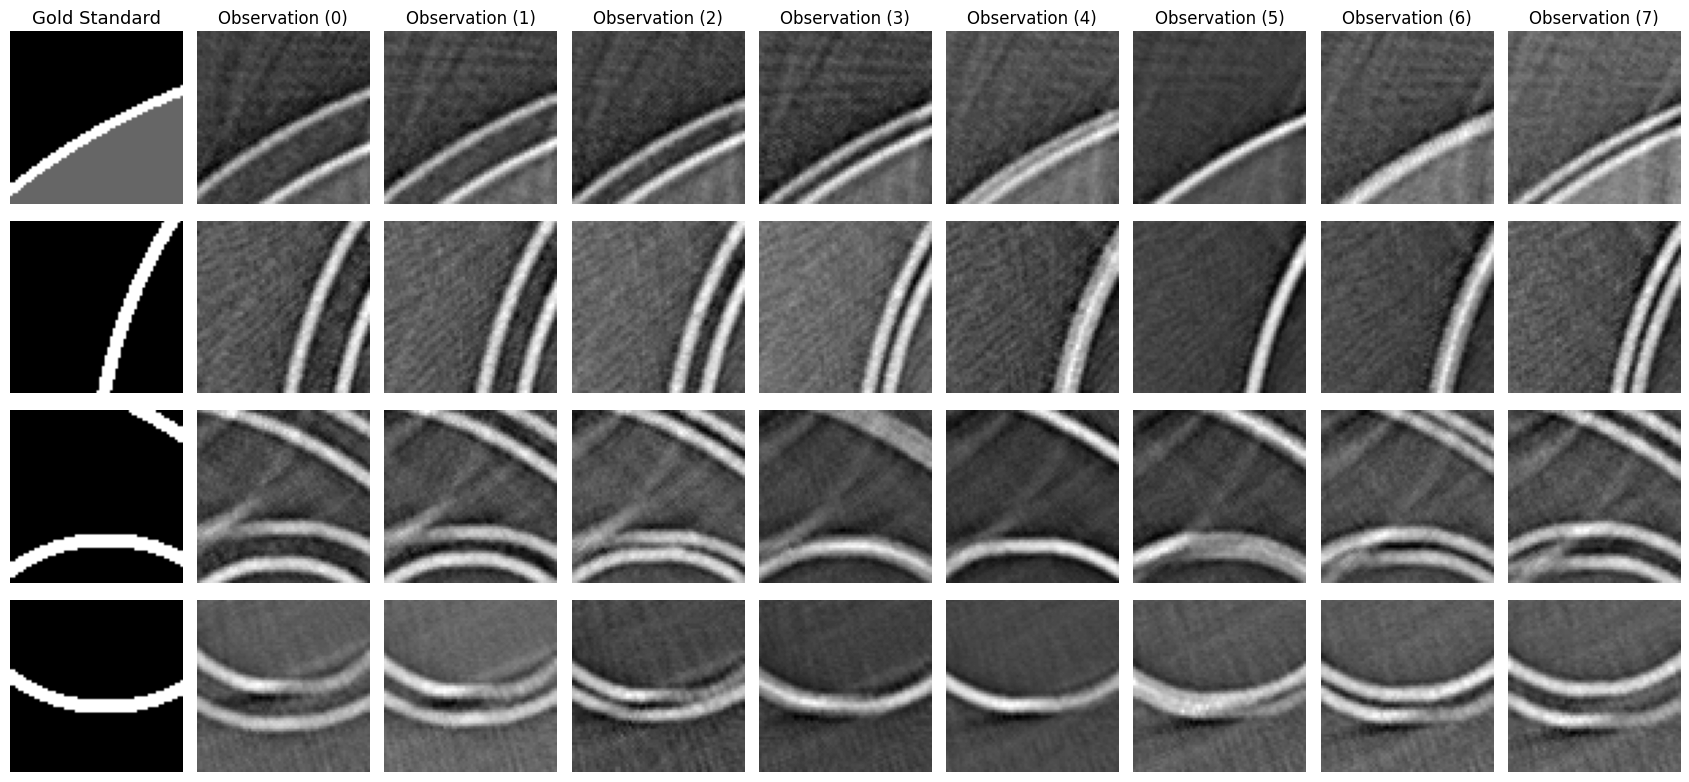

In [116]:
i, j = 4, 3
plt.figure(figsize=(17,8))
for idx, (i,j) in enumerate([(1,4), (7,2), (5,10), (9,10)]):
    plt.subplot(4,9,idx*9+1)
    plt.imshow(IP_img[32*i:32*i+64, 32*j:32*j+64], cmap='gray')
    plt.axis('off')
    if idx == 0:
        plt.title('Gold Standard', fontsize=13)
    for k in range(8):
        plt.subplot(4,9,idx*9+k+2)
        plt.imshow(obs_imgs[k, 32*i:32*i+64, 32*j:32*j+64], cmap='gray')
        plt.axis('off')
        if idx == 0:
            plt.title(f'Observation ({k})')
plt.tight_layout()

### Image with no SoS Distribution

In [117]:
# SoS = np.ones((Ny, Nx)) * 1500
# rou = 1000  # Density.
# medium = kWaveMedium(sound_speed=SoS, sound_speed_ref=SoS_das, density=rou)

In [118]:
# source = kSource()
# source.p0 = IP_pad

# # Smooth the initial pressure distribution and restore the magnitude.
# source.p0 = smooth(source.p0, True)

# cart_sensor_mask = makeCartCircle(R_ring, N_transducer, center_pos, arc_angle)
# sensor = kSensor(cart_sensor_mask) # Assign to sensor structure.

# # Create the time array.
# kgrid.makeTime(medium.sound_speed)
# kgrid.setTime(4000, T_sample) ##

# # Set the input arguements: force the PML to be outside the computational grid switch off p0 smoothing within kspaceFirstOrder2D.
# input_args = {
#     'PMLInside': False,
#     'PMLSize': PML_size,
#     'Smooth': False,
#     'SaveToDisk': os.path.join(pathname, f'example_input.h5'),
#     'SaveToDiskExit': False, 
# }

# # Run the simulation.
# sensor_data_clean = kspaceFirstOrder2DC(**{
#     'medium': medium,
#     'kgrid': kgrid,
#     'source': source,
#     'sensor': sensor,
#     # 'reorder_data': True,
#     **input_args
# })

In [119]:
# sensor_data_clean = sensor_data_clean[:, ::2]

In [120]:
# sensor_data_clean = reorder_binary_sensor_data(sensor_data_clean, sensor, kgrid, PML_size)
# sensor_data_clean = transducer_response(sensor_data_clean)

In [121]:
# fig, ax = plt.subplots(figsize=(12,4))
# plt.title('Photoacoustic Signals', fontsize=15)
# plt.xlabel('Time', fontsize=14)
# plt.ylabel('Detector', fontsize=14)
# plt.imshow(sensor_data_clean)
# cax = fig.add_axes([ax.get_position().x1+0.015, ax.get_position().y0, 0.02, ax.get_position().height])
# plt.colorbar(cax=cax)

In [122]:
# recon_clean = delay_and_sum(R_ring,
#                             1/40e6,
#                             medium.sound_speed_ref,
#                             sensor_data_clean,
#                             kgrid.x_vec[pad_start:pad_end],
#                             kgrid.y_vec[pad_start:pad_end],
#                             d_delay=0)

In [123]:
# fig = plt.figure(figsize=(15,9.5))

# ax1 = plt.subplot(2,3,1)
# plt.imshow(recons[3], cmap='gray')
# plt.title('DAS Reconstruction', fontsize=14)
# plt.ylabel('Image', fontsize=14)
# # cax1 = fig.add_axes([ax1.get_position().x1+0.008, ax1.get_position().y0, 0.012, ax1.get_position().height])
# # cb1 = plt.colorbar(cax=cax1)
# # cb1.ax.tick_params(labelsize=9)
# # cb1.ax.set_yticks([-0.2, -0.1, 0.0,/ 0.1])

# plt.subplot(2,3,4)
# plt.hist(recons[3].ravel(), bins=50)
# # plt.title('Histogram of DAS Reconstruction', fontsize=13)
# plt.ylabel('Histogram', fontsize=14)

# ax2 = plt.subplot(2,3,2)
# plt.imshow(recon_clean, cmap='gray')
# plt.title('DAS Reconstruction (No Distortion)', fontsize=14)
# # cax2 = fig.add_axes([ax2.get_position().x1+0.008, ax2.get_position().y0, 0.012, ax2.get_position().height])
# # cb2 = plt.colorbar(cax=cax2)
# # cb2.ax.tick_params(labelsize=9)
# # cb2.ax.set_yticks([-0.2, -0.1, 0.0, 0.1])

# plt.subplot(2,3,5)
# plt.hist(recon_clean.ravel(), bins=50)
# # plt.title('Histogram of DAS Reconstruction', fontsize=13)

# ax3 = plt.subplot(2,3,3)
# plt.imshow(IP_img, cmap='gray')
# plt.title('Gold Standard', fontsize=14)
# # cax3 = fig.add_axes([ax3.get_position().x1+0.008, ax3.get_position().y0, 0.012, ax3.get_position().height])
# # cb3 = plt.colorbar(cax=cax3)
# # cb3.ax.tick_params(labelsize=9)

# plt.subplot(2,3,6)
# plt.hist(IP_img.ravel(), bins=50)
# plt.title('Histogram of Gold Standard', fontsize=13)

# # plt.savefig('../figures/histogram.jpg', bbox_inches='tight')
# # plt.imsave('../figures/gt.jpg', gt)
# # plt.imsave('../figures/obs.jpg', recons[3])
# # plt.imsave('../figures/rec.jpg', recon_clean)

In [124]:
# print(recon[3].mean(), recon_clean.mean(), IP_img.mean())
# print(np.abs(recon[3]).mean(), np.abs(recon_clean).mean(), np.abs(IP_img).mean())